### Imports and Constants

In [ ]:
import cv2
import numpy as np

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/drive')

DATASET_FOLDER = f'/content/drive/My Drive/Colab Notebooks'
val_img_path = f'{DATASET_FOLDER}/data/val_images/img'
val_masks_path = f'{DATASET_FOLDER}/data/val_masks/img'

MODEL_PATH = f'{DATASET_FOLDER}/model_checkpoints/model-100-unet_resnet50.hdf5'

batch_size = 10
target_size = (256, 256)

### Helper functions

In [74]:
def display_images(img_list):
    f, axarr = plt.subplots(1, len(img_list), figsize=(15,10))
    for x, img in enumerate(img_list):
        axarr[x].imshow(img) if img.shape[-1] == 3 else axarr[x].imshow(img, cmap='gray')
    plt.show()


def image_mask_generator(image_data_generator, mask_data_generator):
    train_generator = zip(image_data_generator, mask_data_generator)
    for (img, mask) in train_generator:
        yield (img/255, to_categorical(mask/255))


def create_generator_pair(img_path, mask_path, seed=13):
    image_data_generator = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, fill_mode='reflect')
    image_data_generator = image_data_generator.flow_from_directory(img_path[:-4],
                                                                    class_mode=None,
                                                                    batch_size=batch_size,
                                                                    target_size=target_size,
                                                                    seed=13)

    mask_data_generator = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, fill_mode='reflect')
    mask_data_generator = mask_data_generator.flow_from_directory(mask_path[:-4],
                                                                  class_mode=None,
                                                                  color_mode='grayscale',
                                                                  batch_size=batch_size,
                                                                  target_size=target_size,
                                                                  seed=13)

    return image_data_generator, mask_data_generator


def regularize_and_clean_results(result_mask):
  # removing small areas
  cleaned_mask = result_mask.copy().astype('uint8')
  kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(7,7))
  cleaned_mask = cv2.morphologyEx(cleaned_mask, cv2.MORPH_OPEN, kernel)

  # striagtening lines of countours
  approx_contours = []
  normalized_mask = np.zeros(cleaned_mask.shape, dtype=np.uint8)
  contours, _ = cv2.findContours(cleaned_mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  for contour in contours:
    epsilon = 0.03 * cv2.arcLength(contour, True)
    approx = cv2.approxPolyDP(contour, epsilon, closed=True)
    normalized_mask = cv2.drawContours(normalized_mask, [approx], -1, 1, thickness=3)
    approx_contours.append(approx)

  return normalized_mask, approx_contours

### Loading of model

In [ ]:
model = tf.keras.models.load_model(MODEL_PATH, compile=False)
val_generator = image_mask_generator(*create_generator_pair(val_img_path, val_masks_path))

### Testing predictions

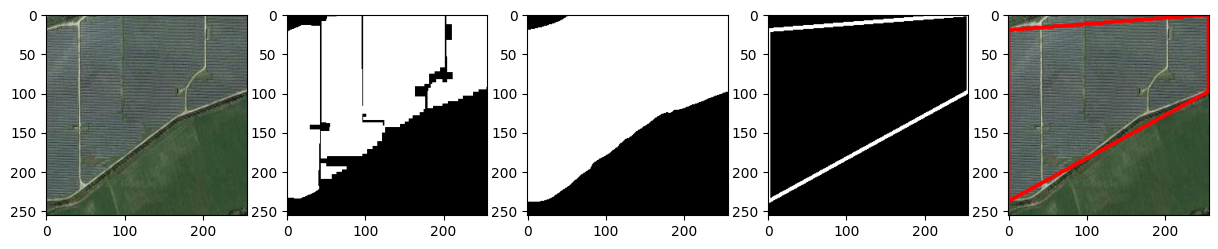

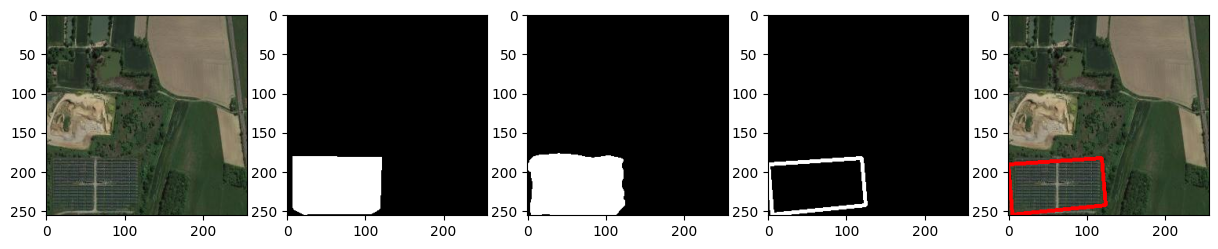

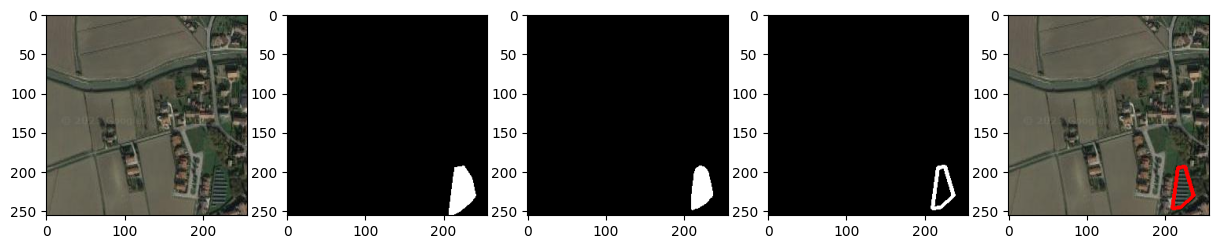

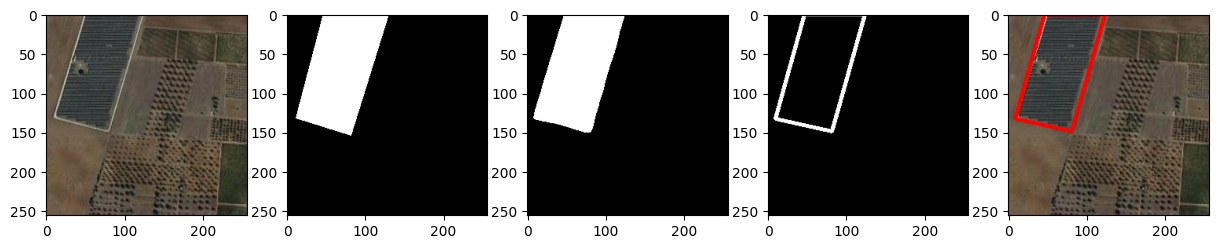

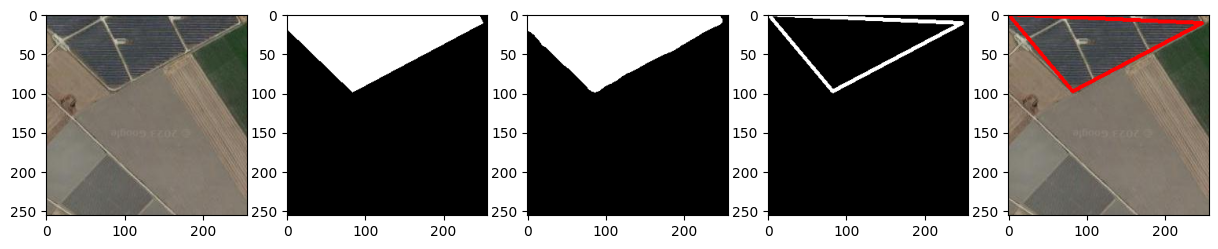

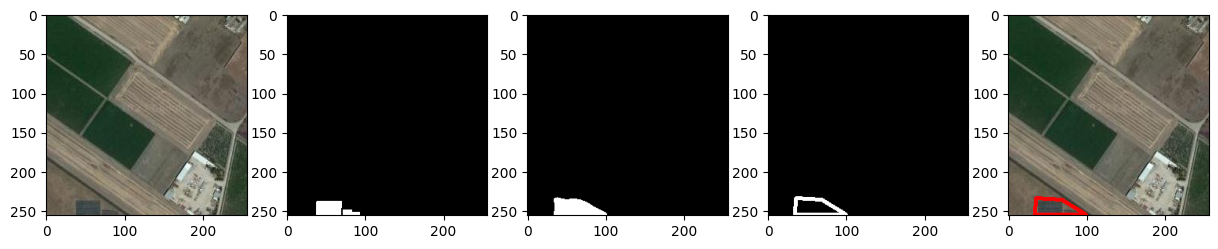

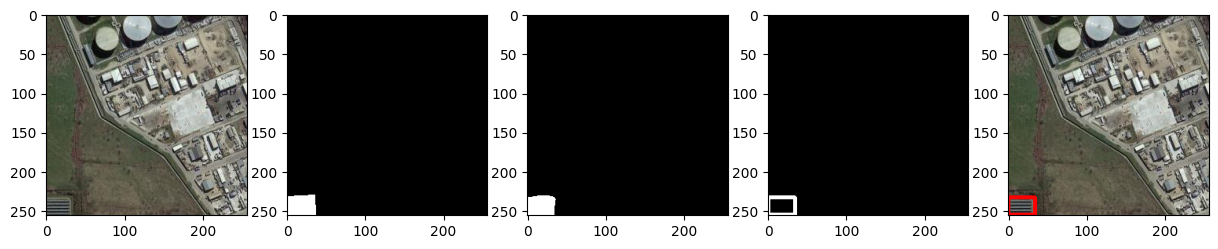

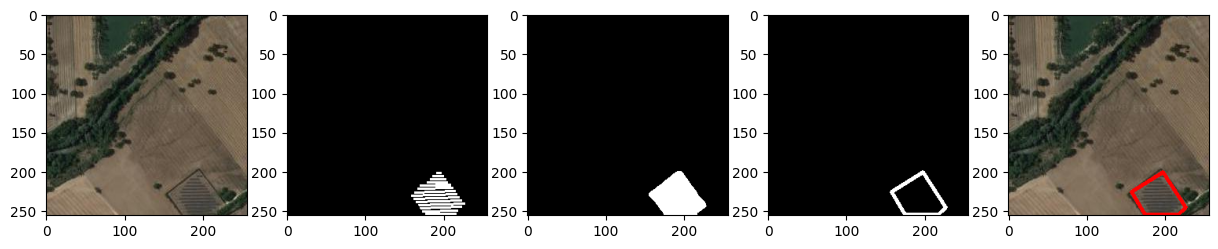

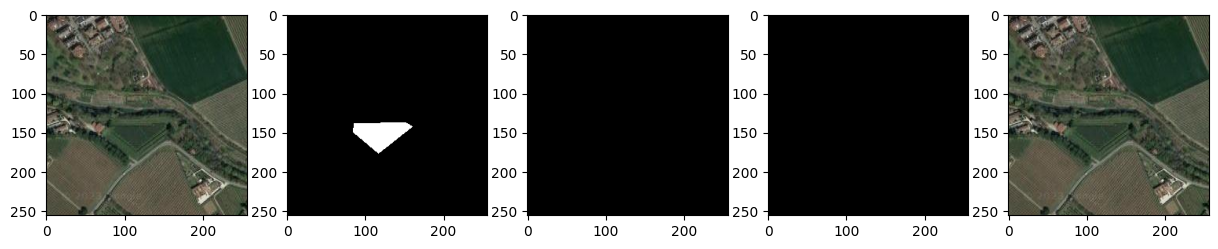

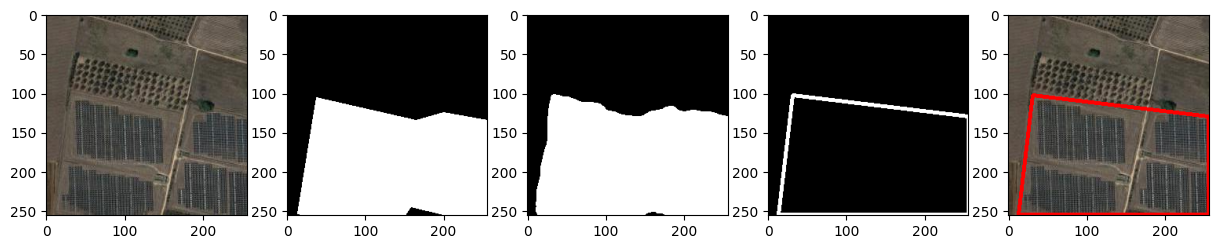

In [75]:
#test_img_batch, test_mask_batch = next(val_generator)
#model_predict = model.predict(test_img_batch)
for img, real_mask, predicted_mask in zip(test_img_batch, test_mask_batch, model_predict):

  # predited [0, 1] at last dimension becuase number of classes was 2
  real_mask = np.argmax(real_mask, -1)
  predicted_mask = np.argmax(predicted_mask, -1)
  cleaned_mask, approx_contours = regularize_and_clean_results(predicted_mask)

  # drawing contour on img
  contour_img = img.copy()
  contour_img = cv2.drawContours(contour_img, approx_contours, -1, (1, 0, 0), 3)

  display_images([img, real_mask, predicted_mask, cleaned_mask, contour_img])